# Import qbiome

In [2]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.mask_checker import MaskChecker
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis
from qbiome.qutil import customDataFormatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
plt.style.use('ggplot')

# Data and initialization

In [ ]:
dirname = 'example_data/'
data = dirname + 'hc_Phylum_GTDB_denoised_filtered_percent.csv'
meta = dirname + 'hc_metadata.csv'
BIOMES=None
BIOMES=['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'Fusobacteriota']

data,property_map=customDataFormatter(data,meta,
                        META_PROP=['hc', 'HCZ', 'sex', 'hc_Birth',
           'HCZ_Birth', 'hc_Discharge', 'HCZ_Discharge',
           'HCZ_discharge_birth_difference', 'HCZ_Category',
           'HCZ_difference_Category', 'NEC', 'IVH', 'ROP', 'BPD', 'Infection',
           'total_Morbidities', 'Morbidity_Category', 'TIMPS score',
           'TIMPS z-score', 'TIMPS Category'],
                        COL_SELECT={"Samples": "sample_id", "PTID": "subject_id", "PMA":"week"},
                                      BIOMES=BIOMES)

data_=data.assign(source='gnd')
quantizer = Quantizer()
qnet_orchestrator = QnetOrchestrator(quantizer)

quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)
dequantized = quantizer.dequantize_to_df(label_matrix)
dequantized_plot = quantizer.melt_into_plot_format(dequantized)
quantizer.fit_random_forest(data, dequantized_plot)

In [321]:
0.2*(1-(np.random.rand()-0.5)*0.5)

0.24652357409037862

# Train qnet

In [322]:
%%time
NUMQ=10
for i in tqdm(np.arange(NUMQ)):
    qnet_orchestrator.train_qnet(
        features, label_matrix, alpha=0.2*(1-(np.random.rand()-0.5)*0.5), min_samples_split=2, 
        out_fname=None)
    qnet_orchestrator.save_qnet('data'+str(i)+'.joblib')
    #qnet_orchestrator.load_qnet('data1.joblib')

100%|██████████| 10/10 [00:36<00:00,  3.65s/it]

CPU times: user 25.1 s, sys: 369 ms, total: 25.5 s
Wall time: 36.5 s


In [323]:
%%time
SW=26
forecasted_dict={}
for i in tqdm(np.arange(NUMQ)):
    qnet_orchestrator_i = QnetOrchestrator(quantizer)
    qnet_orchestrator_i.load_qnet('data'+str(i)+'.joblib')
    forecaster_i = Forecaster(qnet_orchestrator_i)
    # can specify an end week or default to the max end week in the data
    forecasted_dict[i] = forecaster_i.forecast_data(
        label_matrix, 
        start_week=SW).assign(source='forecasted'+str(i))
    

100%|██████████| 10/10 [04:37<00:00, 27.75s/it]

CPU times: user 4min 36s, sys: 665 ms, total: 4min 37s
Wall time: 4min 37s


In [324]:
#forecasted_dict[0]

DF=pd.concat([forecasted_dict[key] for key in np.arange(NUMQ)])

In [325]:
SUBJECTS=DF.subject_id.value_counts().index.values

In [326]:
property_map

,subject_id,hc,HCZ,sex,hc_Birth,HCZ_Birth,hc_Discharge,HCZ_Discharge,HCZ_discharge_birth_difference,HCZ_Category,...,NEC,IVH,ROP,BPD,Infection,total_Morbidities,Morbidity_Category,TIMPS score,TIMPS z-score,TIMPS Category
0,100001,30.0,-0.83,m,23.0,-1.22,35.5,-0.34,0.88,Optimal,...,0,0,0,1,0,1,Mild,NaN,NaN,NaN
1,100001,27.5,-1.27,m,23.0,-1.22,35.5,-0.34,0.88,Optimal,...,0,0,0,1,0,1,Mild,NaN,NaN,NaN
2,100001,27.0,-1.00,m,23.0,-1.22,35.5,-0.34,0.88,Optimal,...,0,0,0,1,0,1,Mild,NaN,NaN,NaN
3,100001,25.0,-1.75,m,23.0,-1.22,35.5,-0.34,0.88,Optimal,...,0,0,0,1,0,1,Mild,NaN,NaN,NaN
4,100002,27.5,-2.58,m,23.0,-1.22,30.0,-2.26,-1.04,Microcephaly,...,0,0,0,1,0,1,Mild,61.0,0.538462,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,100084,29.0,0.66,f,29.0,0.66,30.7,-0.04,-0.70,Optimal,...,0,0,0,0,0,0,None,63.0,0.933333,Normal
130,100084,29.0,0.02,f,29.0,0.66,30.7,-0.04,-0.70,Optimal,...,0,0,0,0,0,0,None,63.0,0.933333,Normal
131,100090,28.0,0.54,f,27.5,-0.45,31.0,-0.55,-0.10,Optimal,...,0,0,0,0,0,0,None,64.0,1.000000,Normal
132,100091,29.5,1.27,m,28.5,0.02,35.5,0.63,0.61,Optimal,...,0,0,0,0,0,0,None,NaN,NaN,NaN


In [327]:
property_map.Infection.value_counts()#[property_map.subject_id==subject_id].drop(['hc','HCZ'],axis=1).drop_duplicates()

0    102
1     32
Name: Infection, dtype: int64

In [328]:
property_map.Morbidity_Category.value_counts()#[property_map.subject_id==subject_id].drop(['hc','HCZ'],axis=1).drop_duplicates()

Severe    63
None      37
Mild      34
Name: Morbidity_Category, dtype: int64

In [350]:
Q=[]
for subject_id in SUBJECTS:
    QF=None
    for i in tqdm(np.arange(NUMQ)):
        DF_=DF[(DF.subject_id==subject_id) 
               & (DF.source=='forecasted'+str(i))] 
        #       & (DF.variable=='Actinobacteriota')]
        #display(DF_)
        qf=quantizer.apply_random_forest_regressor(DF_[DF_.week>=SW]).assign(subject_id=subject_id)
        if QF is None:
            QF=qf.drop('value',axis=1)
            QF['value_'+str(i)]=qf.value
        else:
            QF['value_'+str(i)]=qf.value
    QF=pd.DataFrame(QF.set_index(['variable','week','subject_id']).mean(axis=1),columns=['value']).reset_index()
    y=property_map[property_map.subject_id==subject_id].drop(['hc','HCZ'],axis=1).drop_duplicates().Infection.values[0]
    QF=QF.assign(phn=y)
    Q=Q+[QF]

100%|██████████| 10/10 [00:00<00:00, 10.73it/s]


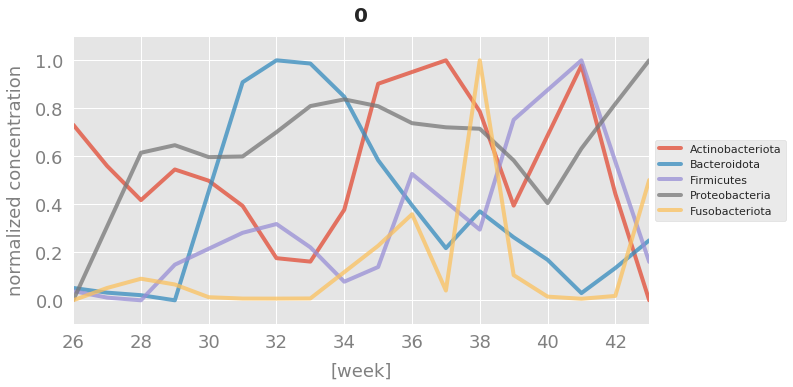

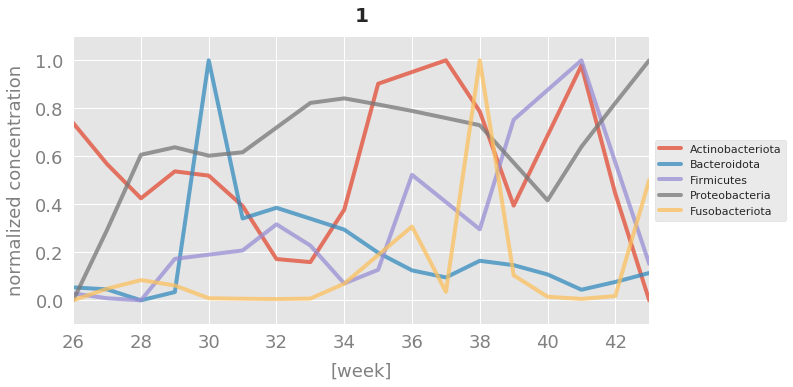

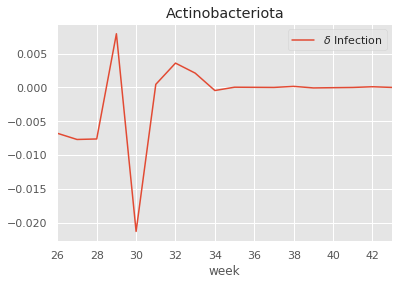

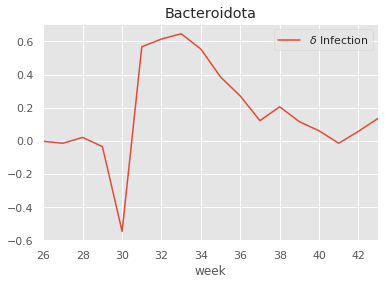

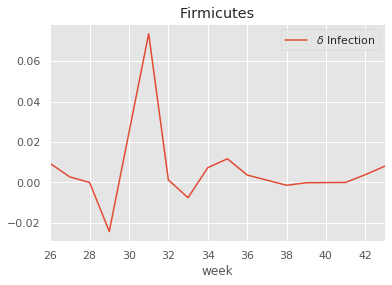

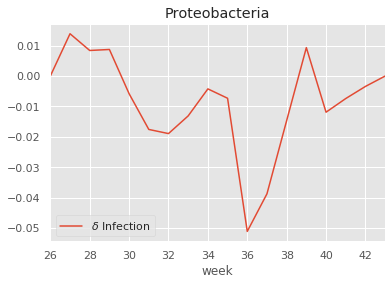

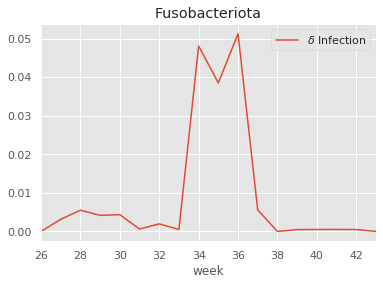

In [353]:
DD=pd.concat(Q)
dd={}
for phn in DD.phn.value_counts().index.values:
    DD_=DD[DD.phn==phn]
    DD_=DD_.groupby(['week','variable']).median().reset_index().drop(['subject_id'],axis=1)
    DD_=DD_.drop_duplicates().assign(phn=phn)
    dd[phn]=qplot(DD_,var=BIOMES,preindex='phn',index='week',columns='variable',
                   interpolate=False,normalize=True,title=phn,lowess_fraction=0.3)

dd_os=dd[0]-dd[1]
#dd_om=dd['None']-dd['Severe']

for i in BIOMES:
    plt.figure()
    ax=plt.gca()
    ax=dd_os[i].plot(ax=ax,label='$\delta$ Infection')
    #ax=dd_om[i].plot(ax=ax,label='$\delta$ Severe')
    ax.legend()
    ax.set_title(i)

In [ ]:
Q=[]
for subject_id in SUBJECTS:
    QF=None
    for i in tqdm(np.arange(NUMQ)):
        DF_=DF[(DF.subject_id==subject_id) 
               & (DF.source=='forecasted'+str(i))] 
        #       & (DF.variable=='Actinobacteriota')]
        #display(DF_)
        qf=quantizer.apply_random_forest_regressor(DF_[DF_.week>=SW]).assign(subject_id=subject_id)
        if QF is None:
            QF=qf.drop('value',axis=1)
            QF['value_'+str(i)]=qf.value
        else:
            QF['value_'+str(i)]=qf.value
    QF=pd.DataFrame(QF.set_index(['variable','week','subject_id']).mean(axis=1),columns=['value']).reset_index()
    y=property_map[property_map.subject_id==subject_id].drop(['hc','HCZ'],axis=1).drop_duplicates().Morbidity_Category.values[0]
    QF=QF.assign(phn=y)
    Q=Q+[QF]

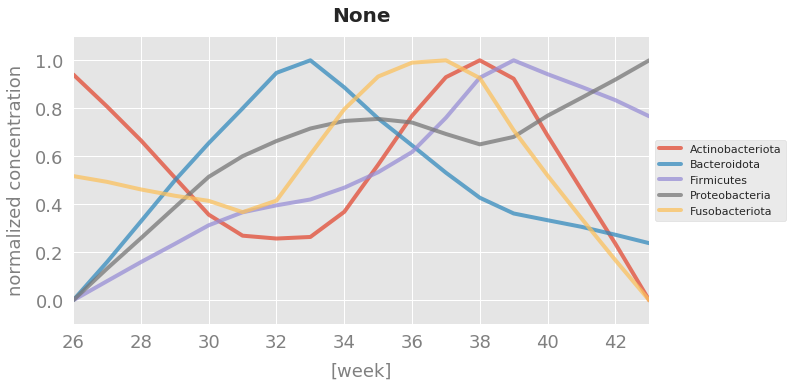

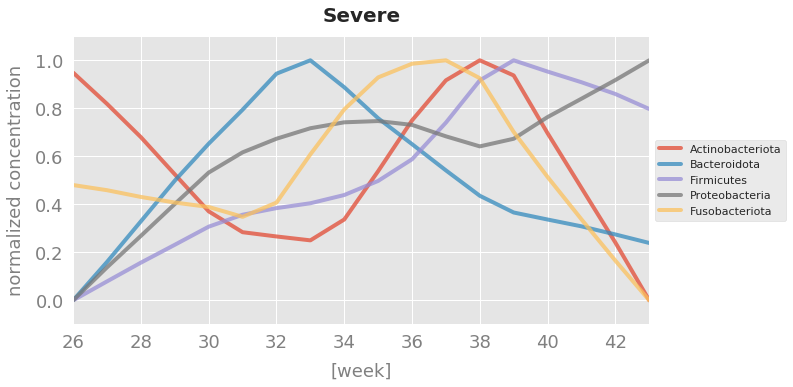

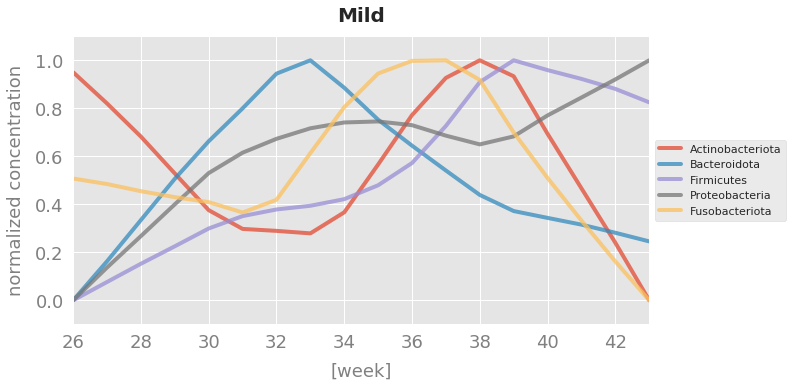

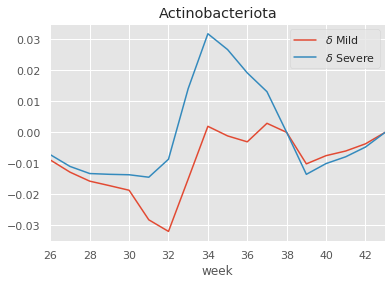

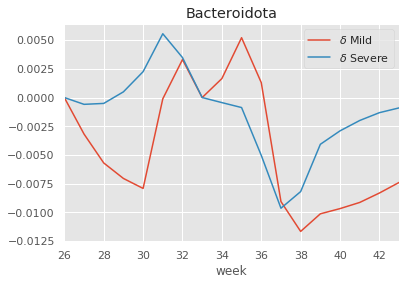

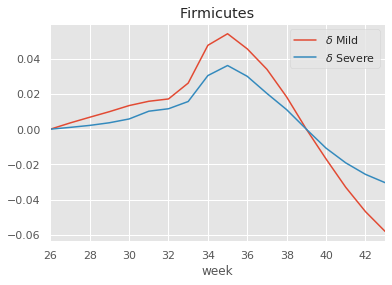

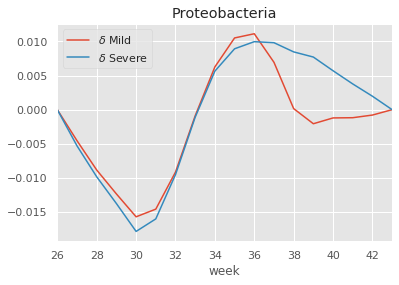

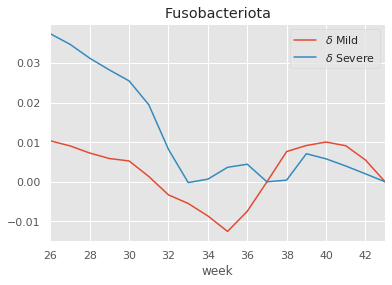

In [349]:
DD=pd.concat(Q)
dd={}
for phn in DD.phn.value_counts().index.values:
    DD_=DD[DD.phn==phn]
    DD_=DD_.groupby(['week','variable']).median().reset_index().drop(['subject_id'],axis=1)
    DD_=DD_.drop_duplicates().assign(phn=phn)
    dd[phn]=qplot(DD_,var=BIOMES,preindex='phn',index='week',columns='variable',
                   interpolate=False,normalize=True,title=phn,lowess_fraction=0.6)

dd_os=dd['None']-dd['Mild']
dd_om=dd['None']-dd['Severe']

for i in BIOMES:
    plt.figure()
    ax=plt.gca()
    ax=dd_os[i].plot(ax=ax,label='$\delta$ Mild')
    ax=dd_om[i].plot(ax=ax,label='$\delta$ Severe')
    ax.legend()
    ax.set_title(i)

In [ ]:
Q=[]
for subject_id in tqdm(SUBJECTS):
    QF=None
    for i in np.arange(NUMQ):
        DF_=DF[(DF.subject_id==subject_id) 
               & (DF.source=='forecasted'+str(i))] 
        #       & (DF.variable=='Actinobacteriota')]
        #display(DF_)
        qf=quantizer.apply_random_forest_regressor(DF_[DF_.week>=SW]).assign(subject_id=subject_id)
        if QF is None:
            QF=qf.drop('value',axis=1)
            QF['value_'+str(i)]=qf.value
        else:
            QF['value_'+str(i)]=qf.value
    QF=pd.DataFrame(QF.set_index(['variable','week','subject_id']).mean(axis=1),columns=['value']).reset_index()
    y=property_map[property_map.subject_id==subject_id].drop(['hc','HCZ'],axis=1).drop_duplicates().HCZ_Category.values[0]
    QF=QF.assign(phn=y)
    Q=Q+[QF]

from qbiome.qutil import qplot
DD=pd.concat(Q)

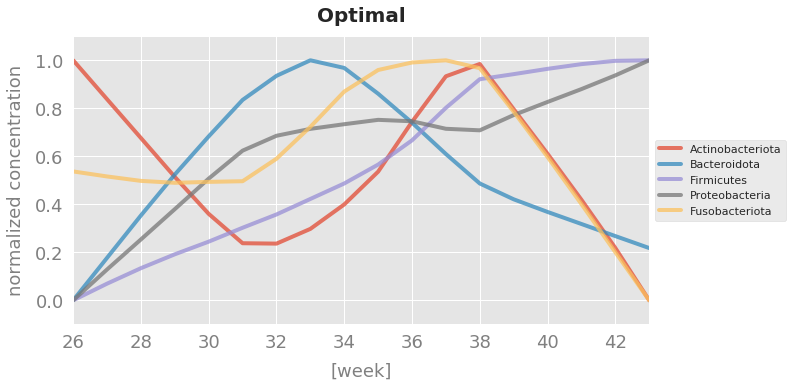

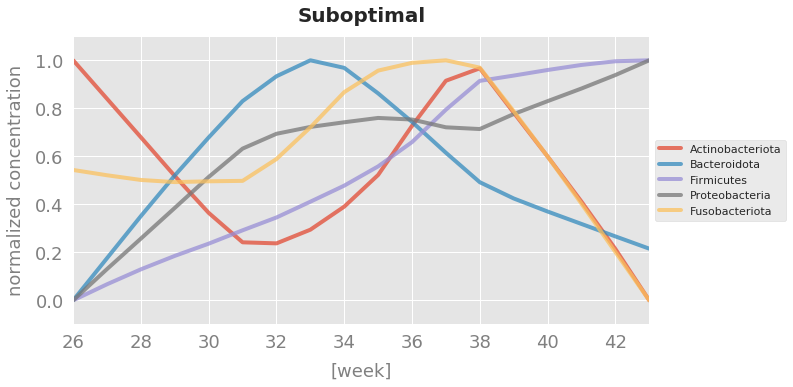

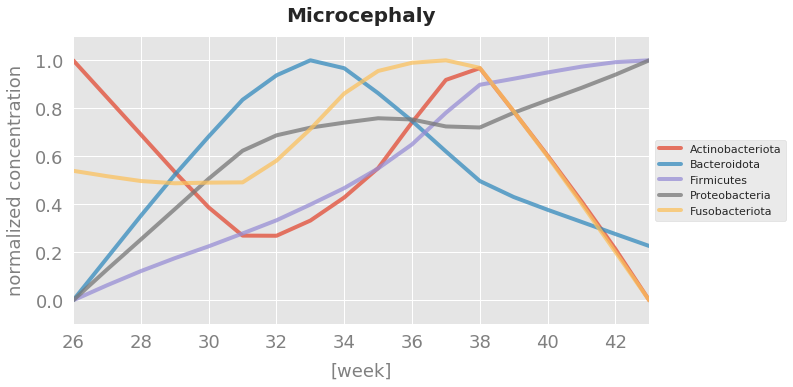

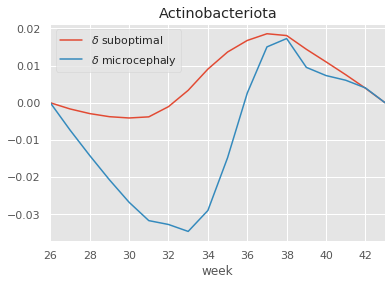

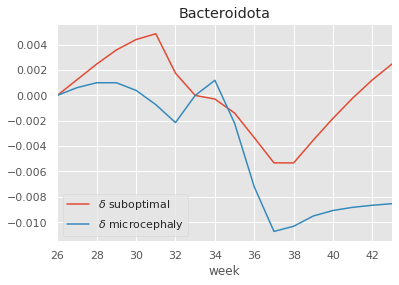

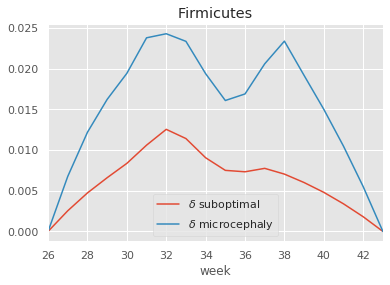

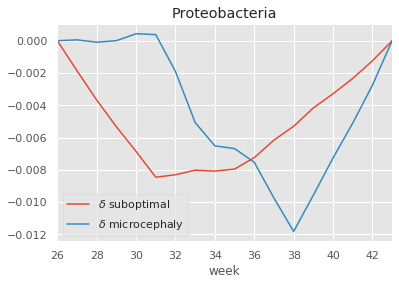

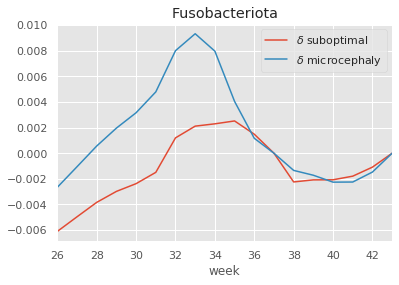

In [347]:
dd={}
for phn in DD.phn.value_counts().index.values:
    DD_=DD[DD.phn==phn]
    DD_=DD_.groupby(['week','variable']).mean().reset_index().drop(['subject_id'],axis=1)
    DD_=DD_.drop_duplicates().assign(phn=phn)
    dd[phn]=qplot(DD_,var=BIOMES,preindex='phn',index='week',columns='variable',
                   interpolate=False,normalize=True,title=phn,lowess_fraction=0.7)

dd_os=dd['Optimal']-dd['Suboptimal']
dd_om=dd['Optimal']-dd['Microcephaly']

for i in BIOMES:
    plt.figure()
    ax=plt.gca()
    ax=dd_os[i].plot(ax=ax,label='$\delta$ suboptimal')
    ax=dd_om[i].plot(ax=ax,label='$\delta$ microcephaly')
    ax.legend()
    ax.set_title(i)

In [343]:
D_dict={}
sid=100015
xx=DD[DD.subject_id==sid].drop(['subject_id','phn'],axis=1).pivot(index='week',columns='variable')
xx.columns=[x[1] for x in xx.columns]
phn=DD[DD.subject_id==sid].phn.values[0]
D_dict[(sid,phn)]=xx
D_dict

{(100015,
  'Microcephaly'):       Actinobacteriota  Bacteroidota  Firmicutes  Fusobacteriota  \
 week                                                               
 26            3.623661      0.709201    6.754249        0.000000   
 27            2.411088      1.996340    2.405898        0.077979   
 28            1.269237      0.123899    4.792491        1.454932   
 29            2.406143      0.857628    5.799764        0.008311   
 30            4.167610      9.783754   24.707421        0.016655   
 31            0.914373      4.119646    6.796837        0.011886   
 32            0.797635      5.994908   11.228866        0.000000   
 33            0.253364      4.594598   12.611183        0.020043   
 34            1.967333      5.929557    2.976616        0.003392   
 35            5.663841      3.863645    5.056258        1.693336   
 36            0.228663      0.052599   16.222172        2.730508   
 37            5.057782      2.106273   28.983646        0.000000   
 38   

# Use the forecaster to predict new data

We construct a new patient from the quantized data column names because it contains all the feature names that the qnet uses.

In [114]:
new_subject_id = '101'
np.random.seed(10001)
# initialize with random floats
new_patient = pd.DataFrame(
    np.random.rand(1, len(quantized.columns)),
    index=[0],
    columns=quantized.columns
)
new_patient.subject_id = new_subject_id
new_patient

,subject_id,Acidobacteriota_24,Acidobacteriota_26,Acidobacteriota_27,Acidobacteriota_28,Acidobacteriota_29,Acidobacteriota_30,Acidobacteriota_31,Acidobacteriota_32,Acidobacteriota_33,...,unclassified_Bacteria_34,unclassified_Bacteria_35,unclassified_Bacteria_36,unclassified_Bacteria_37,unclassified_Bacteria_38,unclassified_Bacteria_39,unclassified_Bacteria_40,unclassified_Bacteria_41,unclassified_Bacteria_42,unclassified_Bacteria_43
0,101,0.116507,0.704285,0.523539,0.1577,0.892232,0.694006,0.900454,0.584406,0.305097,...,0.710015,0.071588,0.980152,0.314483,0.696177,0.005446,0.882128,0.221683,0.077481,0.604916


In [115]:
new_patient_seq = new_patient.drop(columns='subject_id').to_numpy().squeeze()
new_patient_seq.shape

(532,)

In [116]:
# suppose we only have 6 weeks of data for the new patient
# we mask out the remainder of the weeks
new_patient_masked = qnet_orchestrator.mask_sequence_at_weeks(
    new_patient_seq, 
    start_week=29, 
    end_week=qnet_orchestrator.get_max_timestamp(),
    fill_value=np.nan
)

In [117]:
new_patient_df = quantizer.add_meta_to_matrix(
    new_patient_masked[np.newaxis, :],
    add_subject_id=False
)
# manually add back subject_id
new_patient_df.insert(0, 'subject_id', [new_subject_id])
new_patient_df

variable,subject_id,Acidobacteriota_24,Acidobacteriota_26,Acidobacteriota_27,Acidobacteriota_28,Acidobacteriota_29,Acidobacteriota_30,Acidobacteriota_31,Acidobacteriota_32,Acidobacteriota_33,...,unclassified_Bacteria_34,unclassified_Bacteria_35,unclassified_Bacteria_36,unclassified_Bacteria_37,unclassified_Bacteria_38,unclassified_Bacteria_39,unclassified_Bacteria_40,unclassified_Bacteria_41,unclassified_Bacteria_42,unclassified_Bacteria_43
0,101,0.116507,0.704285,0.523539,0.1577,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
new_patient_df = quantizer.melt_into_plot_format(new_patient_df)
new_patient_df

,subject_id,variable,week,value
0,101,Acidobacteriota,24,0.116507
1,101,Acidobacteriota,26,0.704285
2,101,Acidobacteriota,27,0.523539
3,101,Acidobacteriota,28,0.157700
4,101,Acidobacteriota,29,NaN
...,...,...,...,...
527,101,unclassified_Bacteria,39,NaN
528,101,unclassified_Bacteria,40,NaN
529,101,unclassified_Bacteria,41,NaN
530,101,unclassified_Bacteria,42,NaN


In [119]:
# quantize
new_patient_quantized = quantizer.quantize_df(new_patient_df)
# convert this patient into a format acceptable by the qnet
_, new_patient_matrix = quantizer.get_qnet_inputs(new_patient_quantized)
new_patient_matrix.shape

(1, 532)

## Forecast the data starting from week 7 to the last week

In [120]:
# takes 2 minutes to run
new_patient_forecasted = forecaster.forecast_data(
    new_patient_matrix, 
    start_week=29
)

In [121]:
new_patient_forecasted.head()

,subject_id,variable,week,value
0,101,Acidobacteriota,24,NaN
1,101,Acidobacteriota,26,NaN
2,101,Acidobacteriota,27,0.321385
3,101,Acidobacteriota,28,NaN
4,101,Acidobacteriota,29,0.501002


The NaNs are due to the random values we generated falling outside the quantization range.

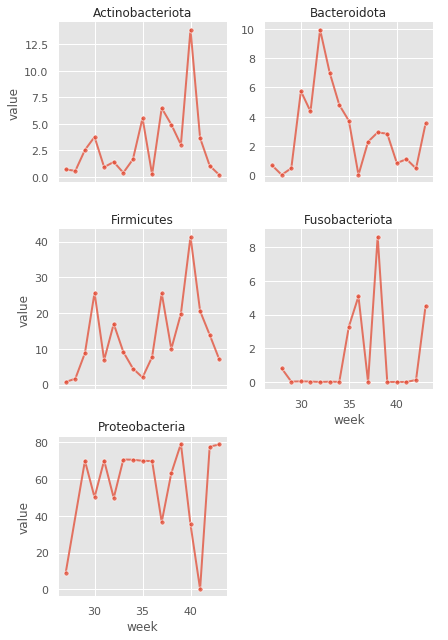

In [122]:
plottable = new_patient_forecasted[new_patient_forecasted.variable.isin(BIOMES)]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

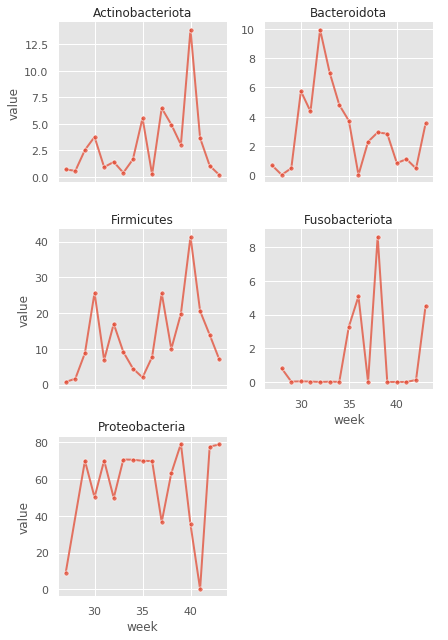

In [123]:
# zoom into the first 20 weeks
plottable = new_patient_forecasted[
    (new_patient_forecasted.variable.isin(BIOMES)) &
    (new_patient_forecasted.week <= 50)
     ]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()